# **DataCollection**

## Objectives

- Fetch data from Kaggle, save as raw data and prepare it for further processes.

## Inputs

- Kaggle JSON file - the token is required for kaggle authentication. 

## Outputs

- Generate the Dataset: inputs/cherry_leaves_dataset.

## Additional Comments

- No additional comments here.


---


# Import packages

In [3]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib
from matplotlib.image import imread

Set Working Directory

In [4]:
cwd= os.getcwd()


You set a new current directory

In [5]:
os.chdir('/workspace/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory



Confirm the new current directory

In [6]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detection-in-cherry-leaves'

---


# Set Input Directories

Sets the train, test and validation paths

In [7]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
valid_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'


Set output directory

In [8]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


Set label names

In [9]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']



Set image shape

In [10]:
import joblib

version = 'v1'
img_shape = joblib.load(filename=f"outputs/{version}/img_shape.pkl")
img_shape

(256, 256, 3)

---


# Images Distribution

These plots will give you a comprehensive view of your dataset's distribution across different labels and sets, which is essential for understanding data balance and preparing for model training.

## Count Number of Images per Set & Label

* train - healthy: 736 images
* train - powdery_mildew: 736 images
* validation - healthy: 105 images
* validation - powdery_mildew: 105 images
* test - healthy: 211 images
* test - powdery_mildew: 211 images




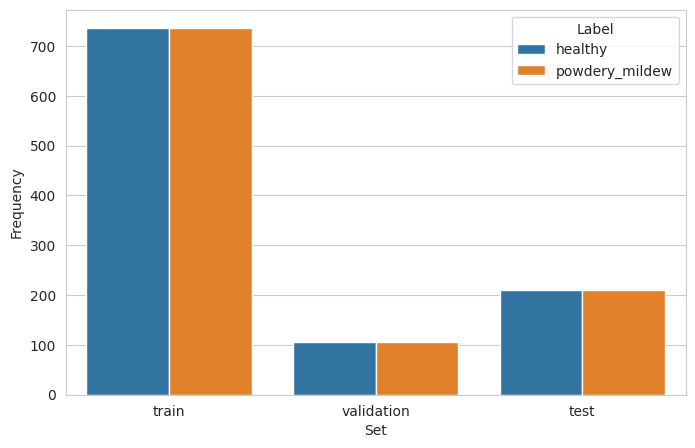

In [11]:

df_img_freq = pd.DataFrame([])

for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_img_freq = df_img_freq.append(
            pd.Series(
                data={
                    'Set': folder,
                    'Label': label,
                    'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
                }
            ),
            ignore_index=True
        )

        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_img_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/label_dist.png', bbox_inches='tight', dpi=150)
plt.show()

---


# Image Data Augmentation

--- 


Import ImageDataGenerator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



Initialize ImageDataGenerator

In [13]:
augmented_img_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

Augment Training Image Set

In [14]:

batch_size = 1
train_set = augmented_img_data.flow_from_directory(
    train_path, 
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

train_set.class_indices

Found 1472 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}


Augment validation Image Set

In [15]:

validation_img_data = ImageDataGenerator(rescale=1./255)
validation_set = validation_img_data.flow_from_directory(
    valid_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

validation_set.class_indices

Found 210 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}


Augment Test Image Set

In [16]:
test_img_data = ImageDataGenerator(rescale=1./255)
test_set = test_img_data.flow_from_directory(                       
    test_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_set.class_indices

Found 422 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}


Plot Augmented Training Image Set

(1, 256, 256, 3)


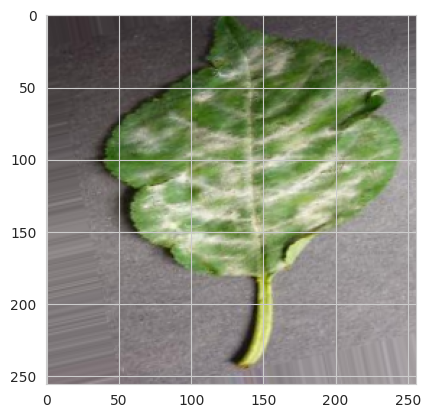

(1, 256, 256, 3)


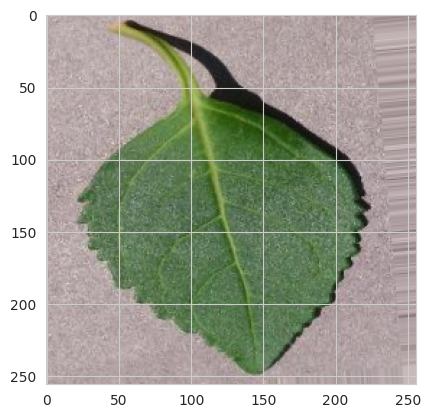

(1, 256, 256, 3)


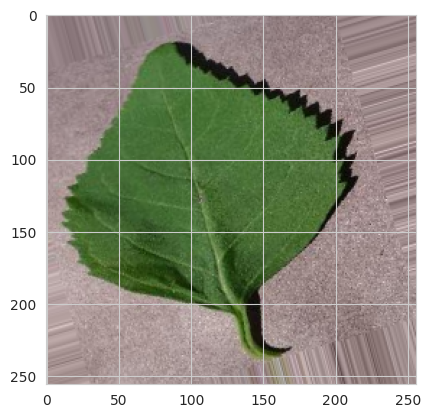

(1, 256, 256, 3)


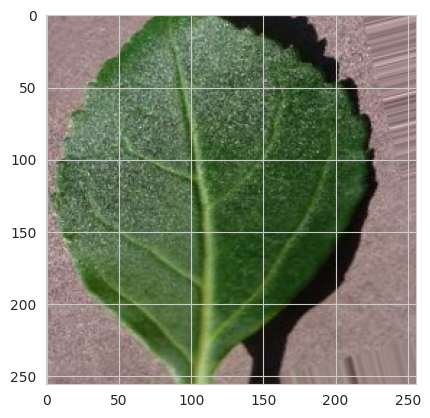

In [17]:
for _ in range(4):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Plot Augmented Validation Image Set

(1, 256, 256, 3)


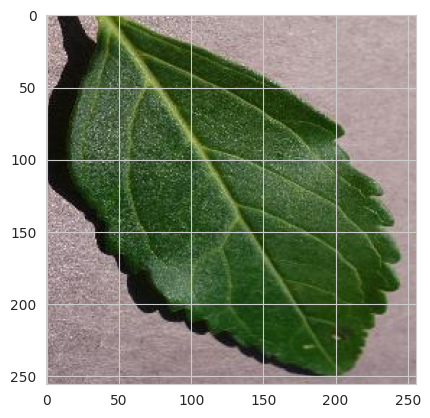

(1, 256, 256, 3)


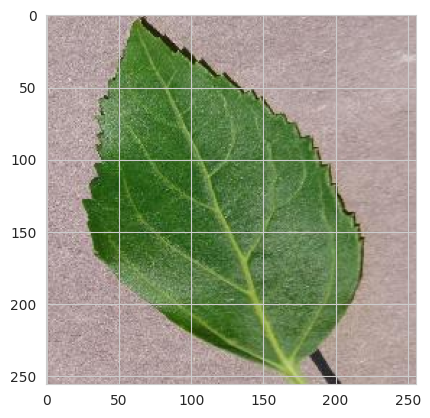

(1, 256, 256, 3)


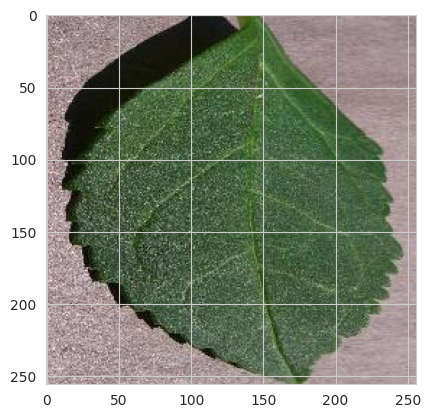

(1, 256, 256, 3)


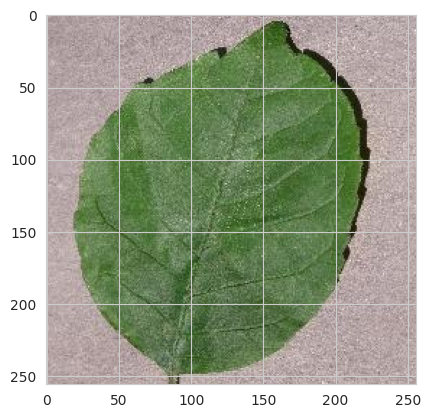

In [18]:
for _ in range(4):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


Plot Augmented Test Image Set

(1, 256, 256, 3)


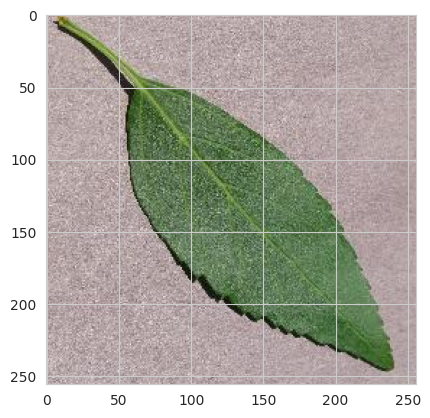

(1, 256, 256, 3)


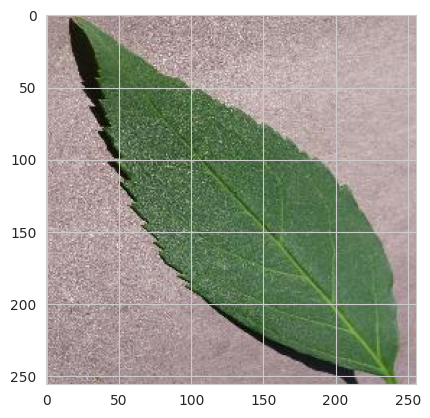

(1, 256, 256, 3)


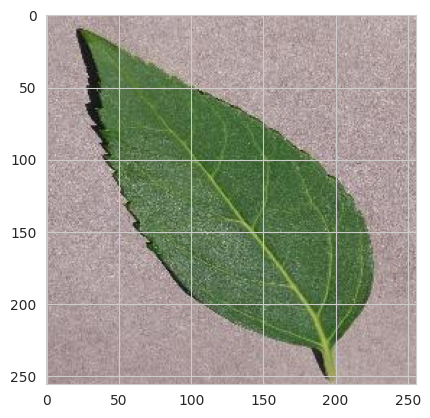

(1, 256, 256, 3)


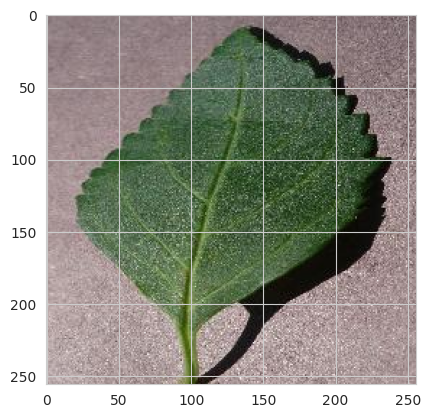

In [19]:
for _ in range(4):
    img, label = test_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()


Save class_indices

In [20]:

joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model Creation

Import Packages

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

ML Model

- The rationale for the model is explored in the README.md file of this project.
- This model answers the Business Requirement #2: it's the final version of the model upon which the predictions will be based

In [22]:
def generate_tf_model():

    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(filters=16, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fifth convolutional layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Prevent overfitting
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])

    return model

Model Summary

In [23]:
model = generate_tf_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

2024-11-24 16:16:53.262732: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


EarlyStopping

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

train_early_stop = EarlyStopping(monitor='val_loss', patience=4)

Fit Model for Model Training

In [30]:
model = generate_tf_model()
history = model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=len(train_set.classes),
    validation_data=validation_set,
    callbacks=[train_early_stop],
    verbose=1
)

Epoch 1/25
1472/1472 [==============================] - 108s 73ms/step - loss: 0.5133 - accuracy: 0.7262 - val_loss: 0.5343 - val_accuracy: 0.6571
Epoch 2/25
1472/1472 [==============================] - 106s 72ms/step - loss: 0.1993 - accuracy: 0.9212 - val_loss: 0.2738 - val_accuracy: 0.8857
Epoch 3/25
1472/1472 [==============================] - 107s 72ms/step - loss: 0.1159 - accuracy: 0.9565 - val_loss: 0.0295 - val_accuracy: 0.9905
Epoch 4/25
1472/1472 [==============================] - 113s 77ms/step - loss: 0.0683 - accuracy: 0.9776 - val_loss: 0.0293 - val_accuracy: 0.9905
Epoch 5/25
1472/1472 [==============================] - 108s 73ms/step - loss: 0.0521 - accuracy: 0.9830 - val_loss: 0.0197 - val_accuracy: 0.9952
Epoch 6/25
1472/1472 [==============================] - 108s 73ms/step - loss: 0.0494 - accuracy: 0.9864 - val_loss: 0.0142 - val_accuracy: 0.9857
Epoch 7/25
1472/1472 [==============================] - 108s 73ms/step - loss: 0.0415 - accuracy: 0.9885 - val_loss: 0

Save model

In [31]:
model.save('outputs/v1/mildew_detector_model.h5')


# Model Performance

### Model Learning Curve A - Training, Validation, Loss & Accuracy Over Epochs

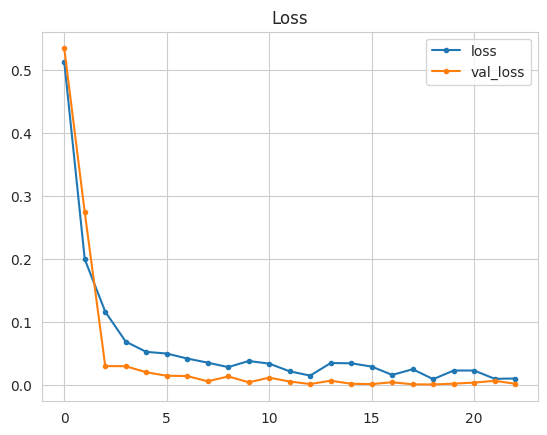

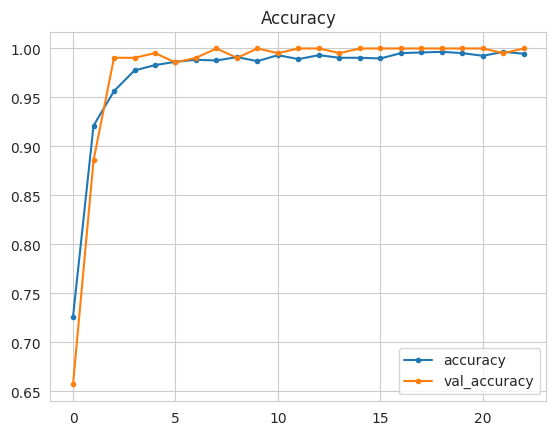

In [32]:

model_training_losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
model_training_losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
model_training_losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_accuracy.png', bbox_inches='tight', dpi=150)
plt.show()

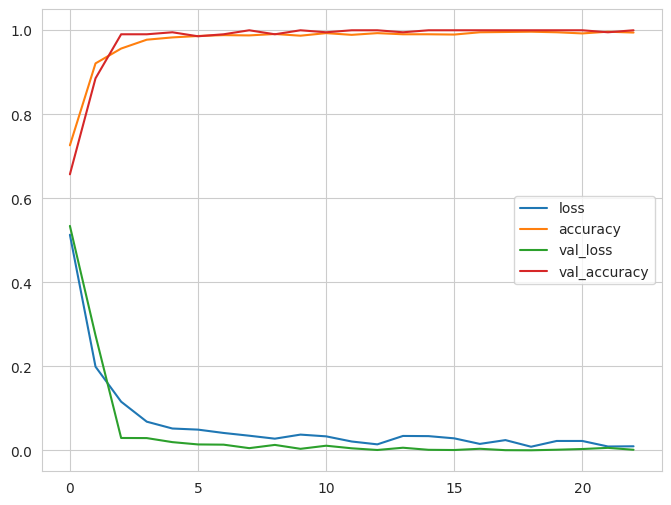

In [33]:
pd.DataFrame(model.history.history).plot(figsize=(8,6))

plt.savefig(f'{file_path}/model_combined.png',
            bbox_inches='tight', dpi=150)
plt.show()

--- 


# Model Evaluation

### Import Packages

In [34]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from keras.models import load_model

### Load Saved Model

In [35]:
model.save('outputs/v1/mildew_model.h5')

### Evaluate Model Accuracy

In [36]:
evaluation = model.evaluate(test_set)

422/422 [==============================] - 8s 20ms/step - loss: 0.0027 - accuracy: 1.0000


### Set Accuracy Variable

In [37]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

### ROC Currve

Area Under ROC-Curve:  0.5


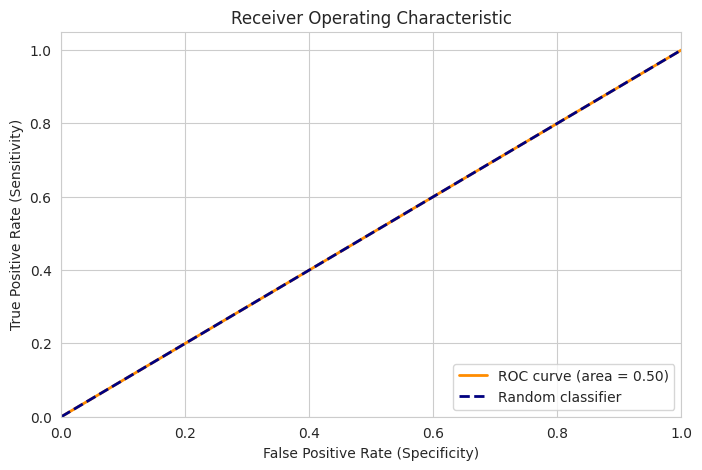

In [38]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

sns.set_style("whitegrid")

fpr, tpr, _ = roc_curve(y_true, y_pred) # fpr: False Positive Rate, tpr: True Positive Rate
roc_auc = auc(fpr, tpr) # Calculate the Area Under the Curve (AUC) for the ROC curve

plt.figure(figsize=(8, 5))

lw = 2

plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, label="Random classifier", linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.title('Receiver Operating Characteristic')

plt.legend(loc="lower right")

plt.savefig(f'{file_path}/roccurve.png',
            bbox_inches='tight', dpi=150)
print('Area Under ROC-Curve: ', roc_auc_score(y_true, y_pred))
plt.show()

### Confusion Matrix

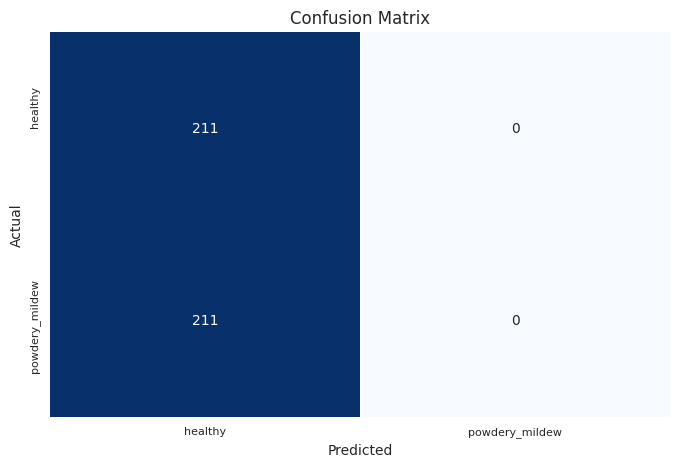

In [39]:
cm = confusion_matrix(y_true,y_pred)

classes=list(test_set.class_indices.keys()) 
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Classification Report - A

In [40]:
print('Classification Report:\n----------------------\n')
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:
----------------------

                precision    recall  f1-score   support

       healthy       0.50      1.00      0.67       211
powdery_mildew       0.00      0.00      0.00       211

      accuracy                           0.50       422
     macro avg       0.25      0.50      0.33       422
  weighted avg       0.25      0.50      0.33       422



/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Classification Report - B

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Classification Report')

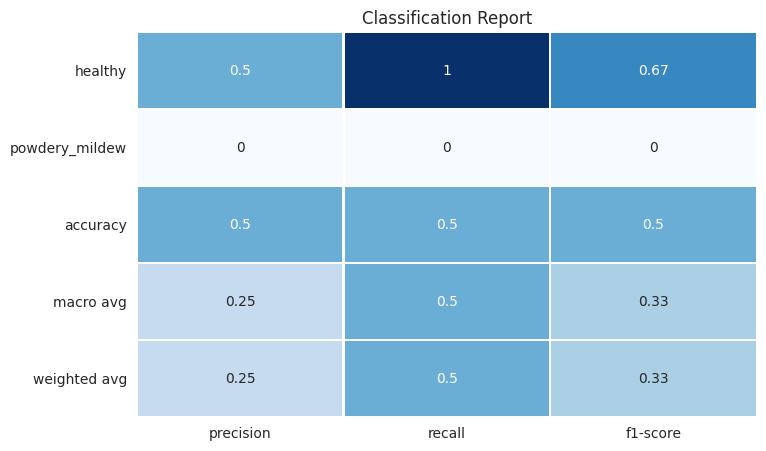

In [43]:
import matplotlib as mpl
clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues", cbar=False, linewidths=1)
plt.title('Classification Report')


### Classificaiton Report - C

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


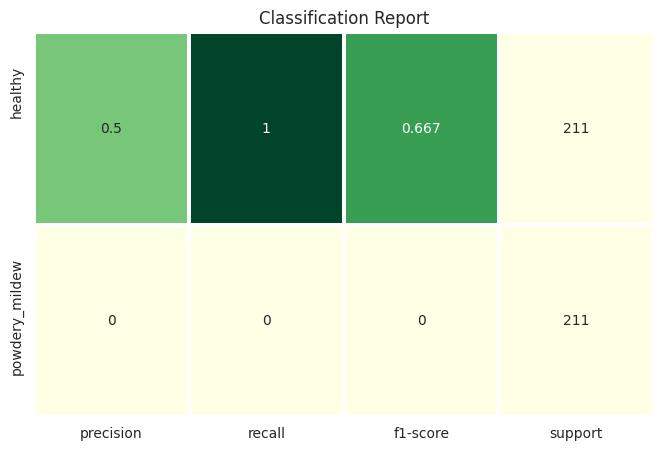

In [44]:
import matplotlib as mpl
import pathlib

def plot_classification_report(y_test, y_pred, title='Classification Report', save_fig_path=None, **kwargs):
    fig, ax = plt.subplots(figsize=(8,5))    
    clf_report = classification_report(y_true, y_pred, output_dict=True, **kwargs)
    keys_to_plot = [key for key in clf_report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
    df = pd.DataFrame(clf_report, columns=keys_to_plot).T
    df.sort_values(by=['support'], inplace=True) 
    
    rows, cols = df.shape
    mask = np.zeros(df.shape)
    mask[:,cols-1] = True
 
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", fmt='.3g', cbar=False,
            vmin=0.0,
            vmax=1.0,
            linewidths=.4, linecolor='white'
                    )
    
    mask = np.zeros(df.shape)
    mask[:,:cols-1] = True    
    
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", cbar=False,
            linewidths=2, linecolor='white', fmt='.0f',
            vmin=df['support'].min(),
            vmax=df['support'].sum(),         
            norm=mpl.colors.Normalize(vmin=df['support'].min(),
                                      vmax=df['support'].sum())
                    ) 
            
    plt.title(title)
    plt.yticks(np.arange(length)+.2, classes, rotation=90)
         
    if (save_fig_path != None):
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path)
    
    return fig, ax

fig, ax = plot_classification_report(y_true, y_pred, 
                    title='Classification Report',
                    target_names=labels,
                    save_fig_path = f'{file_path}/clf_report.png',)

### Save Evaluation Pickle

In [45]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

# Predict On New Data
### Load Random Image as PIL

Image shape: (256, 256), Image mode: RGB


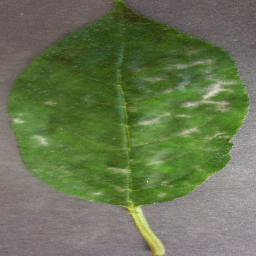

In [49]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # select healthy - 0 or powdery mildew image - 1 

pil_img = image.load_img(
    test_path + '/' + label + '/' + os.listdir(test_path + '/' + label)[pointer],
    target_size=img_shape,
    color_mode='rgb'
)
print(f'Image shape: {pil_img.size}, Image mode: {pil_img.mode}')
pil_img


Convert Image To Array & Prepare for Prediction

In [50]:
my_img = image.img_to_array(pil_img)
my_img = np.expand_dims(my_img, axis=0)/255
print(my_img.shape)

(1, 256, 256, 3)


Predict the class probabilities

In [53]:

proba_predictions = model.predict(my_img)[0, 0]

target_mapping = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_mapping[proba_predictions > 0.97]

if pred_class == target_mapping[0]:
    proba_predictions = 1 - proba_predictions

print(proba_predictions)
print(pred_class)

1.0
powdery_mildew


---


# Push files to Repo

Push new files from this Session to the GitHub repo

- .gitignore

In [54]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

- Git status

In [56]:

!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
